In [2]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)

from keras import backend as K

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 
from keras import metrics
from keras.callbacks import ModelCheckpoint

import pandas as pd 
import math as m
import os, glob

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
ID = "02"
MODEL_NAME = "LSTM"
NUM_FEATURES = 0
TARGET_NAME = "Close"
FRECUENCIA = "1H"
MSE_RESULT = 0

In [5]:
RANGE = 51

HYPER_L1_IN = RANGE
EPOCHS = 100
BATCH_SIZE = 32

TEST_SIZE = .2
VAL_SIZE = .2

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [6]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

EURUSD_ASK_1H_14F.csv
EURUSD_FULL_1D_20F.csv
EURUSD_FULL_1H_20F.csv
EURUSD_FULL_1M_20F.csv
EURUSD_FULL_4H_20F.csv


In [7]:
if FRECUENCIA =="1D":
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
else:
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

DATASET = pd.read_csv(filenames[2], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
DATASET.head()


,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Spread,day_name,weekday,Pct_Range_Close,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200
0,2004-01-01 00:00:00,1.25950,1.25960,1.25826,1.25910,6654.2002,1.25934,1.25948,1.25814,1.25900,7823.1001,0.00010,Thursday,3,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,2004-01-01 01:00:00,1.25958,1.25960,1.25947,1.25951,660.6000,1.25942,1.25948,1.25934,1.25941,461.4000,0.00010,Thursday,3,0.000326,0.000326,0.000000,0.0,0.0,0.0
2,2004-01-01 02:00:00,1.25955,1.25962,1.25944,1.25951,2091.0000,1.25945,1.25948,1.25927,1.25936,1839.8000,0.00015,Thursday,3,0.000000,-0.000326,0.000000,0.0,0.0,0.0
3,2004-01-01 03:00:00,1.25950,1.25965,1.25834,1.25869,10003.0996,1.25934,1.25953,1.25821,1.25854,13349.2998,0.00015,Thursday,3,-0.000651,-0.000651,0.000000,0.0,0.0,0.0
4,2004-01-01 04:00:00,1.25908,1.25960,1.25843,1.25950,7603.3999,1.25898,1.25948,1.25829,1.25940,8422.5000,0.00010,Thursday,3,0.000644,0.001295,1.259262,0.0,0.0,0.0


In [8]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())

#Remove Day_name Column and Timestamp
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (102514, 20)
                Open           High            Low          Close  \
count  102514.000000  102514.000000  102514.000000  102514.000000   
mean        1.264046       1.265085       1.263008       1.264047   
std         0.122828       0.123008       0.122629       0.122829   
min         1.035600       1.037040       1.034050       1.035630   
25%         1.149838       1.150705       1.149015       1.149833   
50%         1.270655       1.271820       1.269425       1.270670   
75%         1.350917       1.352038       1.349740       1.350920   
max         1.601460       1.604030       1.598830       1.601570   

              Volume       Open_Bid       High_Bid        Low_Bid  \
count  102514.000000  102514.000000  102514.000000  102514.000000   
mean    20711.113359       1.263956       1.265001       1.262923   
std     32706.529958       0.122803       0.122983       0.122604   
min         0.380000       1.035580       1.037020       1.034030   
25%      498

In [9]:
#Remove first 200 rows because MA200 is 0
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(102315, 18)
      Open     High      Low    Close      Volume  Open_Bid  High_Bid  \
0  1.27584  1.27666  1.27351  1.27436  25980.0000   1.27580   1.27649   
1  1.27435  1.27891  1.27331  1.27891  24881.5996   1.27419   1.27884   
2  1.27890  1.27957  1.27550  1.27552  24909.9004   1.27880   1.27947   
3  1.27523  1.27566  1.27374  1.27462  26329.6992   1.27513   1.27555   
4  1.27465  1.27482  1.27195  1.27277  25984.5000   1.27449   1.27467   

   Low_Bid  Close_Bid  Volume_Bid   Spread  weekday  Pct_Range_Close  \
0  1.27341    1.27426  30272.0996  0.00010        1        -0.001176   
1  1.27318    1.27871  28934.9004  0.00020        1         0.003570   
2  1.27536    1.27538  32662.0000  0.00014        1        -0.002651   
3  1.27358    1.27452  31190.5996  0.00010        1        -0.000706   
4  1.27184    1.27262  32288.5996  0.00015        1        -0.001451   

   Pct_Range_Close_diff  MA_Close_5  MA_Close_25  MA_Close_50  MA_Close_200  
0             -0.001270    1.275586  

In [10]:
#Shape 
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  102315
Start:  0


In [11]:
#Shape the first START of the total and Number of Features
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)

NUM_FEATURES = DF_Full.shape[1]
print("NUM_FEATURES = ",NUM_FEATURES)

(102315, 18)
NUM_FEATURES =  18


In [12]:
#VECTOR Y
TARGET_INDEX = DF_Full.columns.get_loc(TARGET_NAME)
print("index column: ",TARGET_INDEX)
print('VECTOR Y: ' + DF_Full[TARGET_NAME].name)
close_y = DF_Full[TARGET_NAME].iloc[1:]
close_y.columns = [TARGET_NAME+'_y']
print(close_y.head())
print(close_y.shape)
close_y = close_y.append(close_y.tail(1), ignore_index=True)
print(close_y.tail())
print(close_y.shape)

index column:  3
VECTOR Y: Close
1    1.27891
2    1.27552
3    1.27462
4    1.27277
5    1.27501
Name: Close, dtype: float64
(102314,)
102310    1.11071
102311    1.11141
102312    1.11123
102313    1.11158
102314    1.11158
Name: Close, dtype: float64
(102315,)


In [13]:
#Define INDEX for Subsets for Training, Testing and Validation

s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.4
count of Val and Test: 40926
end of train:  61389
count val:  20463
count test:  20463
end_val 81852


In [14]:
#Generate Subsets for Training, Testing and Validation
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print(data_training.shape)
print(data_val.shape)
print(data_test.shape)


#For Target Y Vector
data_training_y = close_y.iloc[:end_train]
data_val_y = close_y.iloc[end_train: end_val]
data_test_y = close_y.iloc[end_val:]

print(data_training_y.shape)
print(data_val_y.shape)
print(data_test_y.shape)

(61389, 18)
(20463, 18)
(20463, 18)
(61389,)
(20463,)
(20463,)


In [15]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
#print(data_training.head)
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[0.25422564 0.25222138 0.25153572 ... 0.25816889 0.26050411 0.23410251]
 [0.25081306 0.25736084 0.25107558 ... 0.25750726 0.26077648 0.23434066]
 [0.26123403 0.25886841 0.25611411 ... 0.25627148 0.26093784 0.23453313]
 ...
 [0.4215336  0.41878526 0.42367422 ... 0.42576394 0.44060368 0.48287123]
 [0.42265586 0.41912789 0.42441045 ... 0.42521863 0.43960592 0.48253197]
 [0.42315973 0.4228283  0.42493961 ... 0.42475894 0.43870648 0.48220954]]


(61389, 18)


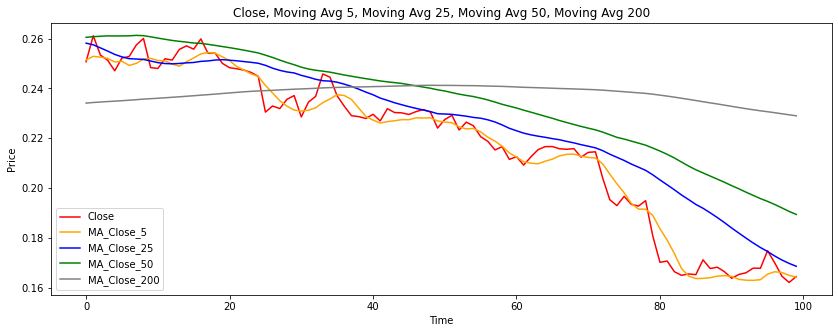

In [16]:
INICIO = 0
FIN = 100

IDX_Close = DF_Full.columns.get_loc("Close")
IDX_MA_Close_5 = DF_Full.columns.get_loc("MA_Close_5")
IDX_MA_Close_25 = DF_Full.columns.get_loc("MA_Close_25")
IDX_MA_Close_50 = DF_Full.columns.get_loc("MA_Close_50")
IDX_MA_Close_200 = DF_Full.columns.get_loc("MA_Close_200")

print(data_training_array_scaled.shape)
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_5], color = 'orange', label = 'MA_Close_5')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_25], color = 'blue', label = 'MA_Close_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_50], color = 'green', label = 'MA_Close_50')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_200], color = 'gray', label = 'MA_Close_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(61389, 18)


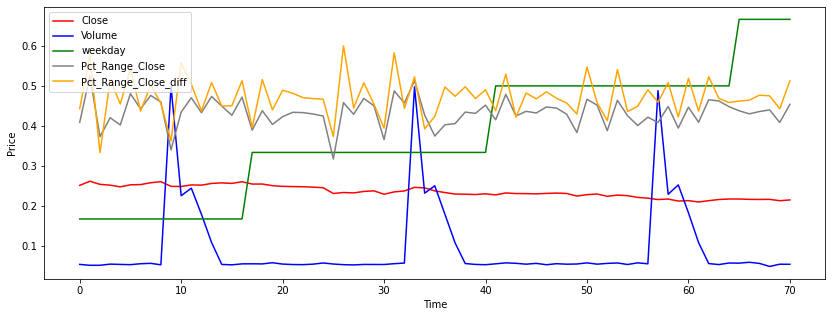

In [17]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 71


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Volume = DF_Full.columns.get_loc("Volume")
IDX_weekday = DF_Full.columns.get_loc("weekday")
IDX_Pct_Range_Close = DF_Full.columns.get_loc("Pct_Range_Close")
IDX_Pct_Range_Close_diff = DF_Full.columns.get_loc("Pct_Range_Close_diff")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Volume], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_weekday], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close_diff], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(61389, 18)


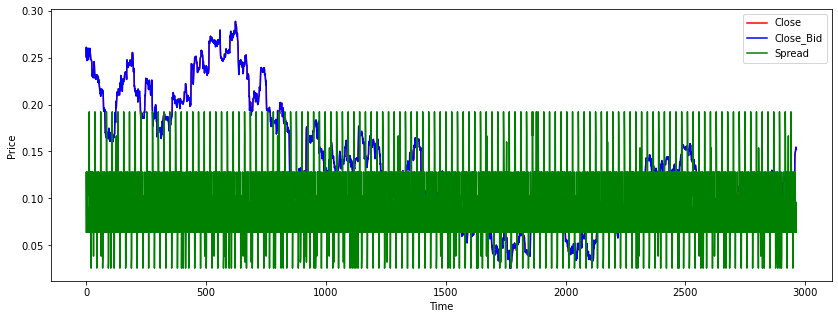

In [18]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 2963


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Close_Bid = DF_Full.columns.get_loc("Close_Bid")
IDX_Spread = DF_Full.columns.get_loc("Spread")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close_Bid], color = 'blue', label = 'Close_Bid')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Spread], color = 'green', label = 'Spread')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(61389, 18)


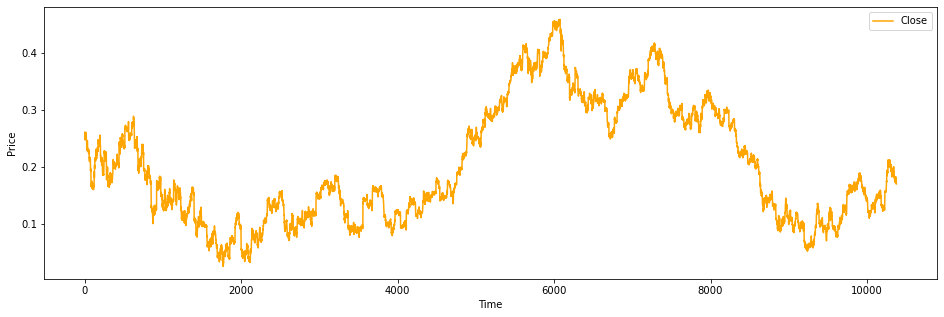

In [19]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 10377
plt.figure(figsize=(16,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,TARGET_INDEX], color = 'orange', label = TARGET_NAME)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

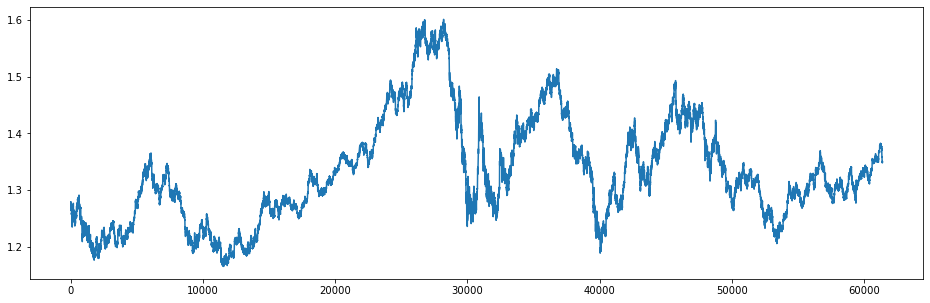

In [20]:
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [21]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(61338, 51, 18)
(61338,)


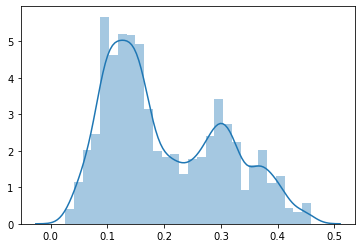

In [22]:
sns.distplot(data_training_array_scaled[INICIO:FIN,TARGET_INDEX]);


In [23]:

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(51, 18)
(20463, 18)
<bound method NDFrame.head of           Open     High      Low    Close      Volume  Open_Bid  High_Bid  \
0      1.37085  1.37113  1.36896  1.37014   7081.9399   1.37083   1.37112   
1      1.37014  1.37110  1.36947  1.37057   5953.7798   1.37012   1.37105   
2      1.37058  1.37065  1.36933  1.36995   9999.2900   1.37054   1.37062   
3      1.36995  1.37158  1.36995  1.37116  12962.8496   1.36994   1.37153   
4      1.37115  1.37128  1.36910  1.36939  16223.2100   1.37114   1.37127   
...        ...      ...      ...      ...         ...       ...       ...   
20509  1.05558  1.05583  1.05428  1.05530  11370.1299   1.05557   1.05581   
20510  1.05529  1.05612  1.05481  1.05571  10134.2695   1.05528   1.05610   
20511  1.05571  1.05610  1.05502  1.05534  10124.4297   1.05569   1.05608   
20512  1.05539  1.05584  1.05216  1.05342  18621.6992   1.05537   1.05582   
20513  1.05344  1.05651  1.05316  1.05613  19404.3496   1.05343   1.05649   

       Low_Bid  Close_Bi

In [24]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y.tail(RANGE)
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = last_range_train_y.append(data_val_y, ignore_index = True)
data_val_y1.shape
print(data_val_y1.head(10))

(51,)
(20463,)
0    1.37057
1    1.36995
2    1.37116
3    1.36939
4    1.36593
5    1.36382
6    1.36426
7    1.36209
8    1.36177
9    1.35941
Name: Close, dtype: float64


In [25]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[0.47182905 0.46800978 0.4711377  0.47004809 0.01437853 0.47207715
  0.46837958 0.47121334 0.47030803 0.01037381 0.00641026 0.5
  0.42537524 0.46241507 0.4736336  0.48084915 0.48468338 0.49088321]
 [0.47020292 0.46794125 0.47231105 0.47103275 0.01208352 0.4704508
  0.46821971 0.47245543 0.47122409 0.00912442 0.02564103 0.5
  0.44515534 0.48941012 0.47216816 0.48052904 0.4843555  0.49090833]
 [0.47121066 0.46691336 0.47198896 0.46961301 0.02031328 0.47141286
  0.46723764 0.47213341 0.46984999 0.0166479  0.01282051 0.5
  0.42644222 0.45428003 0.47077206 0.48011122 0.4839914  0.49093009]
 [0.46976776 0.46903767 0.47341539 0.47238379 0.02634204 0.47003848
  0.46931598 0.47360552 0.47262109 0.02308643 0.01282051 0.5
  0.45906208 0.50112809 0.47086914 0.47983112 0.48363482 0.49097445]
 [0.47251615 0.46835241 0.4714598  0.46833066 0.03297458 0.47278725
  0.46872217 0.47155837 0.4684759  0.02742783 0.03846154 0.5
  0.4059631  0.42289844 0.47020807 0.4791453  0.4832486  0.49099886]
 [0.4683935

In [26]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(20463, 51, 18)
(20463,)


In [27]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(51, 18)
(20463, 18)


(20514, 18)

In [28]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y.tail(RANGE)
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = last_range_training_y.append(data_test_y, ignore_index = True)
data_test_y1.shape

(51,)
(20463,)


(20514,)

In [29]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[0.47182905 0.46800978 0.4711377  0.47004809 0.01437853 0.47207715
  0.46837958 0.47121334 0.47030803 0.01037381 0.00641026 0.5
  0.42537524 0.46241507 0.4736336  0.48084915 0.48468338 0.49088321]
 [0.47020292 0.46794125 0.47231105 0.47103275 0.01208352 0.4704508
  0.46821971 0.47245543 0.47122409 0.00912442 0.02564103 0.5
  0.44515534 0.48941012 0.47216816 0.48052904 0.4843555  0.49090833]
 [0.47121066 0.46691336 0.47198896 0.46961301 0.02031328 0.47141286
  0.46723764 0.47213341 0.46984999 0.0166479  0.01282051 0.5
  0.42644222 0.45428003 0.47077206 0.48011122 0.4839914  0.49093009]
 [0.46976776 0.46903767 0.47341539 0.47238379 0.02634204 0.47003848
  0.46931598 0.47360552 0.47262109 0.02308643 0.01282051 0.5
  0.45906208 0.50112809 0.47086914 0.47983112 0.48363482 0.49097445]
 [0.47251615 0.46835241 0.4714598  0.46833066 0.03297458 0.47278725
  0.46872217 0.47155837 0.4684759  0.02742783 0.03846154 0.5
  0.4059631  0.42289844 0.47020807 0.4791453  0.4832486  0.49099886]
 [0.4683935

In [30]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(20463, 51, 18)
(20463,)


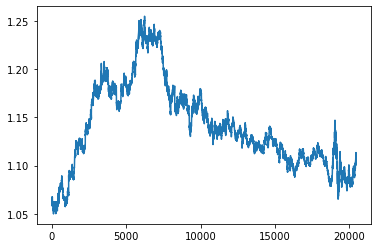

In [31]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

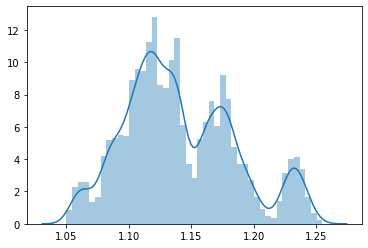

In [32]:
sns.distplot(y_test_np);


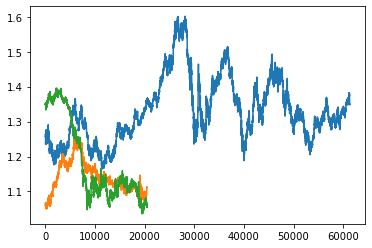

In [33]:

# Y de Val y Test comparados
pyplot.plot(y_train_np)
pyplot.plot(y_test_np)
pyplot.plot(y_val_np)


In [34]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

51
18


In [35]:
regressior = Sequential()

regressior.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
#regressior.add(Dropout(0.2))
regressior.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))
regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))
regressior.add(LSTM(units = 120, activation = 'relu'))
#regressior.add(Dropout(0.2))
regressior.add(Dense(units = 1))

In [36]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [37]:
regressior.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

In [38]:
regressior.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 51, 51)            14280     
_________________________________________________________________
lstm_1 (LSTM)                (None, 51, 60)            26880     
_________________________________________________________________
lstm_2 (LSTM)                (None, 51, 80)            45120     
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               96480     
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 182,881
Trainable params: 182,881
Non-trainable params: 0
_________________________________________________________________


In [39]:
pwd = os.getcwd()
source_data = os.path.join(pwd, r'../../../Models/2020/LSTM/')
print(source_data)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models\../../../Models/2020/LSTM/


In [53]:
#Model check pointer para almacenar el modelo cada epoca
checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [54]:
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)



Epoch 1/100
1917/1917 [==============================] - 284s 148ms/step - loss: 4.2956 - mean_squared_error: 4.2956 - mean_absolute_error: 0.0776 - mean_absolute_percentage_error: 5.6920 - cosine_proximity: 1.0000 - val_loss: 3.3998e-04 - val_mean_squared_error: 3.3998e-04 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 1.2803 - val_cosine_proximity: 1.0000
Epoch 2/100
1917/1917 [==============================] - 281s 146ms/step - loss: 5.0603e-05 - mean_squared_error: 5.0603e-05 - mean_absolute_error: 0.0055 - mean_absolute_percentage_error: 0.4118 - cosine_proximity: 1.0000 - val_loss: 3.1517e-04 - val_mean_squared_error: 3.1517e-04 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 1.1830 - val_cosine_proximity: 1.0000
Epoch 3/100
1917/1917 [==============================] - 275s 143ms/step - loss: 5.2868e-05 - mean_squared_error: 5.2868e-05 - mean_absolute_error: 0.0057 - mean_absolute_percentage_error: 0.4239 - cosine_proximity: 1.0000

Epoch 22/100
1917/1917 [==============================] - 281s 146ms/step - loss: 1.4091e-05 - mean_squared_error: 1.4091e-05 - mean_absolute_error: 0.0029 - mean_absolute_percentage_error: 0.2136 - cosine_proximity: 1.0000 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0306 - val_mean_absolute_percentage_error: 2.7933 - val_cosine_proximity: 1.0000
Epoch 23/100
1917/1917 [==============================] - 286s 149ms/step - loss: 1.4670e-05 - mean_squared_error: 1.4670e-05 - mean_absolute_error: 0.0029 - mean_absolute_percentage_error: 0.2170 - cosine_proximity: 1.0000 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0296 - val_mean_absolute_percentage_error: 2.6978 - val_cosine_proximity: 1.0000
Epoch 24/100
1917/1917 [==============================] - 279s 146ms/step - loss: 1.3544e-05 - mean_squared_error: 1.3544e-05 - mean_absolute_error: 0.0027 - mean_absolute_percentage_error: 0.2055 - cosine_proximity: 1.0000 - va

1917/1917 [==============================] - 287s 150ms/step - loss: 1.0929e-05 - mean_squared_error: 1.0929e-05 - mean_absolute_error: 0.0025 - mean_absolute_percentage_error: 0.1860 - cosine_proximity: 1.0000 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0372 - val_mean_absolute_percentage_error: 3.4299 - val_cosine_proximity: 1.0000
Epoch 44/100
1917/1917 [==============================] - 293s 153ms/step - loss: 1.0855e-05 - mean_squared_error: 1.0855e-05 - mean_absolute_error: 0.0025 - mean_absolute_percentage_error: 0.1845 - cosine_proximity: 1.0000 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 3.8496 - val_cosine_proximity: 1.0000
Epoch 45/100
1917/1917 [==============================] - 284s 148ms/step - loss: 1.0141e-05 - mean_squared_error: 1.0141e-05 - mean_absolute_error: 0.0024 - mean_absolute_percentage_error: 0.1773 - cosine_proximity: 1.0000 - val_loss: 0.008

1917/1917 [==============================] - 285s 149ms/step - loss: 9.5085e-06 - mean_squared_error: 9.5085e-06 - mean_absolute_error: 0.0023 - mean_absolute_percentage_error: 0.1691 - cosine_proximity: 1.0000 - val_loss: 0.0707 - val_mean_squared_error: 0.0707 - val_mean_absolute_error: 0.1155 - val_mean_absolute_percentage_error: 10.7783 - val_cosine_proximity: 1.0000
Epoch 65/100
1917/1917 [==============================] - 287s 150ms/step - loss: 9.6102e-06 - mean_squared_error: 9.6102e-06 - mean_absolute_error: 0.0023 - mean_absolute_percentage_error: 0.1708 - cosine_proximity: 1.0000 - val_loss: 0.0768 - val_mean_squared_error: 0.0768 - val_mean_absolute_error: 0.1209 - val_mean_absolute_percentage_error: 11.2553 - val_cosine_proximity: 1.0000
Epoch 66/100
1917/1917 [==============================] - 286s 149ms/step - loss: 9.2314e-06 - mean_squared_error: 9.2314e-06 - mean_absolute_error: 0.0022 - mean_absolute_percentage_error: 0.1671 - cosine_proximity: 1.0000 - val_loss: 0.0

1917/1917 [==============================] - 282s 147ms/step - loss: 9.0153e-06 - mean_squared_error: 9.0153e-06 - mean_absolute_error: 0.0022 - mean_absolute_percentage_error: 0.1640 - cosine_proximity: 1.0000 - val_loss: 0.5802 - val_mean_squared_error: 0.5802 - val_mean_absolute_error: 0.2839 - val_mean_absolute_percentage_error: 26.6388 - val_cosine_proximity: 1.0000
Epoch 86/100
1917/1917 [==============================] - 287s 150ms/step - loss: 8.9458e-06 - mean_squared_error: 8.9458e-06 - mean_absolute_error: 0.0022 - mean_absolute_percentage_error: 0.1632 - cosine_proximity: 1.0000 - val_loss: 0.5393 - val_mean_squared_error: 0.5393 - val_mean_absolute_error: 0.2697 - val_mean_absolute_percentage_error: 25.3078 - val_cosine_proximity: 1.0000
Epoch 87/100
1917/1917 [==============================] - 281s 147ms/step - loss: 8.8102e-06 - mean_squared_error: 8.8102e-06 - mean_absolute_error: 0.0022 - mean_absolute_percentage_error: 0.1617 - cosine_proximity: 1.0000 - val_loss: 0.9

In [42]:
file_name = MODEL_NAME + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + TARGET_NAME + "_"+ ID + '.hdf5'
print(file_name)


LSTM_1H_18F_Close_02.hdf5


In [ ]:
regressior.save(source_data + file_name)

In [56]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'val_cosine_proximity'])


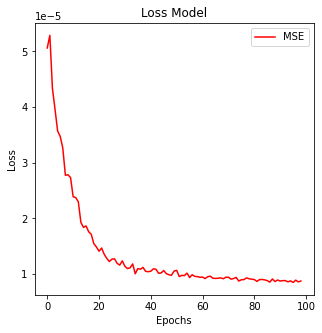

In [57]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
#plt.plot(history.history['val_loss'][1:], color = 'blue', label = 'Val_Loss')
plt.plot(history.history['mean_squared_error'][1:], color = 'red', label = 'MSE')
#plt.plot(history.history['mean_absolute_error'][1:], color = 'blue', label = 'MAE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

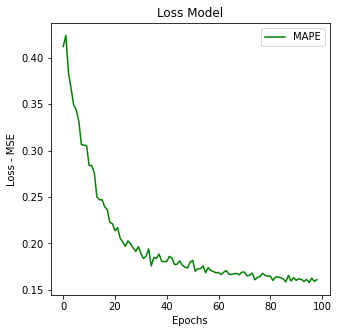

In [58]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
plt.plot(history.history['mean_absolute_percentage_error'][1:], color = 'green', label = 'MAPE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()
plt.show()


In [43]:
#Load Model
filepath = os.path.join(source_data, file_name)
print(filepath)
model = tf.keras.models.load_model(filepath)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models\../../../Models/2020/LSTM/LSTM_1H_18F_Close_02.hdf5


In [44]:
y_test_pred = model.predict(X_test_np)
y_test_pred.shape



(20463, 1)

In [45]:
numpy_data = np.array(y_test_pred)
yhat = pd.DataFrame(data=numpy_data, columns=["Prediction"])
print(yhat)
#data_test['prediction'] = yhat
#print(data_test.tail)

       Prediction
0        1.350057
1        1.277628
2        1.251632
3        1.222174
4        1.224866
...           ...
20458    1.211671
20459    1.210390
20460    1.209106
20461    1.208709
20462    1.207878

[20463 rows x 1 columns]


In [46]:
y_train_pred = model.predict(X_train_np)
y_train_pred.shape


(61338, 1)

(20463,)
(20463, 1)


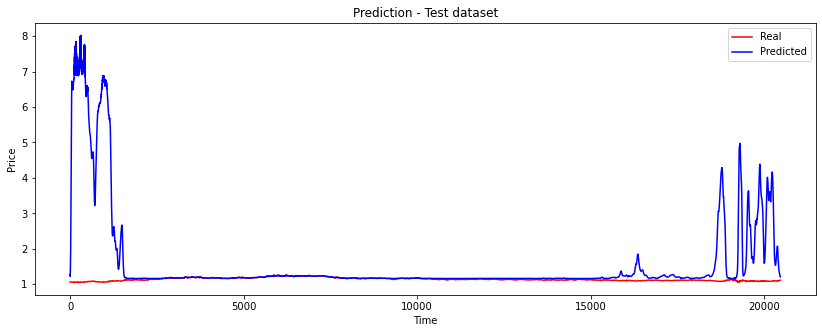

In [74]:
INICIO = 0
FIN = 20463
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_test_pred[INICIO:FIN][1:], color = 'blue', label = 'Predicted')
plt.title('Prediction - Test dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [60]:
print(data_test.head)

<bound method NDFrame.head of            Open     High      Low    Close      Volume  Open_Bid  High_Bid  \
81852   1.05612  1.05807  1.05600  1.05736  23109.4395   1.05608   1.05805   
81853   1.05738  1.06094  1.05728  1.05967  19560.0898   1.05737   1.06092   
81854   1.05964  1.06058  1.05812  1.05839  12669.5498   1.05963   1.06056   
81855   1.05840  1.05915  1.05808  1.05898   8602.4902   1.05838   1.05914   
81856   1.05897  1.05926  1.05822  1.05894   6760.8999   1.05896   1.05923   
...         ...      ...      ...      ...         ...       ...       ...   
102310  1.10998  1.11070  1.10862  1.10998  12120.8398   1.10995   1.11066   
102311  1.10997  1.11094  1.10982  1.11071   4646.7427   1.10993   1.11085   
102312  1.11213  1.11217  1.11136  1.11141    417.4906   1.11129   1.11194   
102313  1.11138  1.11148  1.11028  1.11123   4549.1167   1.11130   1.11144   
102314  1.11123  1.11199  1.11119  1.11158   5159.8101   1.11119   1.11195   

        Low_Bid  Close_Bid  Volum

In [61]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [62]:
print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error


Test MAE: 0.4678221016480784
Test RMSE: 1.3594913236531547
Test MSE: 1.8482166590882068
Test MAPE: 42.10505324925894


(61338,)
(61338, 1)


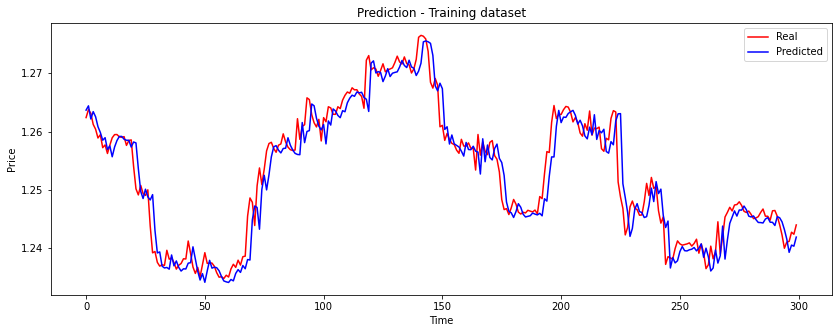

In [69]:
INICIO = 0
FIN = 300
print(y_train_np.shape)
print(y_train_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_train_pred[INICIO:FIN][:], color = 'blue', label = 'Predicted')
plt.title('Prediction - Training dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [71]:
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(y_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
#print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error


Train MAE: 0.001779746389904294
Train RMSE: 0.0025897085245222408
Train MSE: 6.706590241983162e-06
